In [1]:
from gibbs.dataclass import GibbsResult
import matplotlib.pyplot as plt
import numpy as np
from gibbs.learning.bayesian_learning import BayesianLearning
from gibbs.learning.constraint_matrix import ConstraintMatrixFactory
from qiskit.quantum_info import Statevector
from gibbs.learning.klocal_pauli_basis import KLocalPauliBasis
from scipy.linalg import block_diag
from scipy.sparse import bmat

from gibbs.utils import number_of_elements, simple_purify_hamiltonian, spectral_dec
# plt.rcParams['text.usetex'] = True

%load_ext autoreload
%autoreload 2

In [2]:
n=4
k=2
nfields = 5
basisH = KLocalPauliBasis(k,n,False)
cmat = ConstraintMatrixFactory(n,k,k+1)
c_original = np.zeros(basisH.size)
c_original[basisH.pauli_to_num("XXII"):basisH.pauli_to_num("IIXX")+1]=1
c_original_prior = c_original.copy()
c_original[basisH.pauli_to_num("XXII"):] += np.random.normal(0,0.1,size=c_original[basisH.pauli_to_num("XXII"):].size)

/home/drudis/python_environements/test_easy_instalation/lib64/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


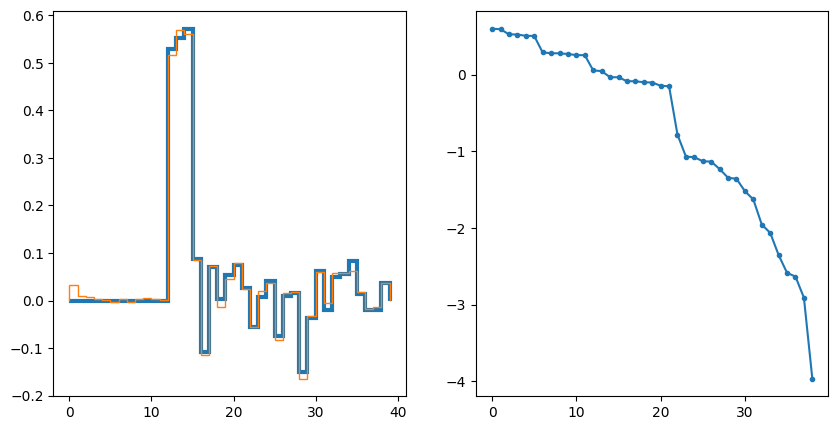

In [3]:
s,v = spectral_dec(cmat.create_constraint_matrix(simple_purify_hamiltonian(basisH.vector_to_pauli_op(c_original)),shots=100_000))
candidate = v[-1].copy(); candidate /= np.linalg.norm(candidate)
if np.linalg.norm(c_original/np.linalg.norm(c_original) + candidate) < np.linalg.norm(c_original/np.linalg.norm(c_original) - candidate):
    candidate = -candidate
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].stairs(c_original/np.linalg.norm(c_original),lw=3)
ax[0].stairs(candidate)
ax[1].plot(np.log(s),marker=".")

In [4]:
control_fields = [np.zeros(basisH.size) for _ in range(nfields+1)]
for i,cf in enumerate(control_fields[1:]):
    cf[i*5:(i+1)*5] = -0.25
    cf += np.random.normal(0,1e-2)
states = [simple_purify_hamiltonian(basisH.vector_to_pauli_op(c_original+cf)) for cf in control_fields]
constraint_matrices = [cmat.create_constraint_matrix(state,shots=100_000) for state in states]

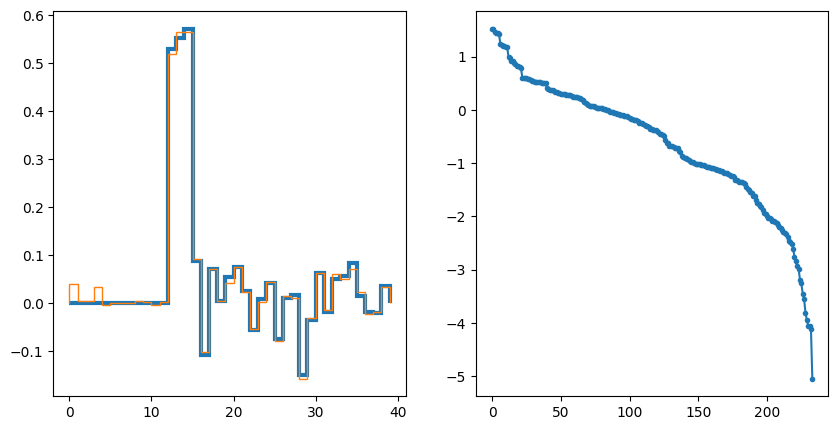

In [5]:
A = bmat([[constraint_matrices[0]]+[None]*(len(constraint_matrices)-1)]+[[c]+[None]*i + [c] +[None]*(len(constraint_matrices)-i-2) for i,c in enumerate(constraint_matrices[1:])])
s,v = spectral_dec(A)
candidate = v[-1][:c_original.size].copy(); candidate /= np.linalg.norm(candidate)
if np.linalg.norm(c_original/np.linalg.norm(c_original) + candidate) < np.linalg.norm(c_original/np.linalg.norm(c_original) - candidate):
    candidate = -candidate
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].stairs(c_original/np.linalg.norm(c_original),lw=3)
ax[0].stairs(candidate)
ax[1].plot(np.log(s),marker=".")

In [6]:
shots = 100_000
bl = BayesianLearning(
    states=states,
    control_fields= control_fields,
    constraint_matrix_factory= ConstraintMatrixFactory(4,2,2),
    prior_mean=c_original_prior,
    prior_c_cov=np.eye(c_original.shape[0])*1e-1,
    prior_cfield_cov=np.eye(c_original.shape[0])*1e-2,
    sampling_std= 1/np.sqrt(shots),
    shots = shots,
)

In [7]:
# for i in range(1,nfields+1):
#     update = bl.update_mean(i)
#     cov = bl.update_cov(update,i)
#     bl.current_mean = update[:update.size//2]
#     bl.total_cov = cov
update = bl.update_mean(1)
cov = bl.update_cov(update,1)

/home/drudis/python_environements/test_easy_instalation/lib64/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:107: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x0).astype(float)
/home/drudis/python_environements/test_easy_instalation/lib64/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:243: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)


The time it takes for minimize is: 49.74880790710449 for the rest: 1.4871087074279785
The cost function ends up with a value of:0.7664440947337363, it started with a value of 2.74370324179541


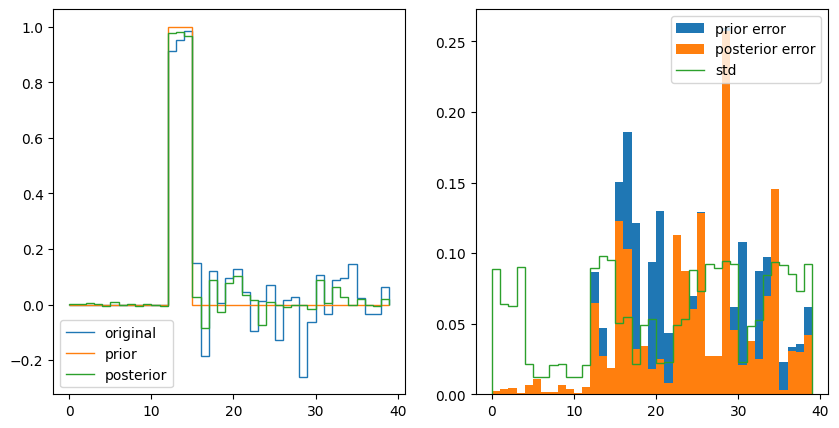

In [8]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].stairs(c_original,label="original")
ax[0].stairs(c_original_prior,label = "prior")
ax[0].stairs(update[:c_original.size],label="posterior")
ax[0].legend()
ax[1].stairs(np.abs(c_original-c_original_prior),label="prior error",lw=2,fill=True)
ax[1].stairs(np.abs(c_original-update[:c_original.size]),label="posterior error",fill=True)
ax[1].stairs(cov.diagonal()[:c_original.size],label="std")
ax[1].legend()


In [9]:
cmat = bl.block_control_matrix([bl.constraint_matrix(0),bl.constraint_matrix(1)])
bl._cost_function(update,0,A=cmat,Lx=bl.Lx)

30.421544698844066